# Plot ROC curves 

# 1. Set up

In [ ]:
 from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 3283325480043567450
 xla_global_id: -1, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 16154099712
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 1193086483316391368
 physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
 xla_global_id: 416903419]

In [ ]:
!pip install tensorflow-addons --quiet

In [ ]:
import numpy as np 
import pandas as pd
from matplotlib import pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.models import Model, save_model, load_model
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.applications.vgg19 import preprocess_input
import tensorflow_addons as tfa
import os
import tempfile


from keras.utils.vis_utils import plot_model

import sklearn
from sklearn import metrics
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import RocCurveDisplay

In [ ]:
# Define paths:
pathtoCSV = '/content/drive/Shareddrives/Eye_Tracking_NN_SD/Image_processing/Publishable_material/CSV_Files/'
pathtoImages = '/content/drive/Shareddrives/Eye_Tracking_NN_SD/Image_processing/Publishable_material/Images/'
pathtoSave = '/content/drive/Shareddrives/Eye_Tracking_NN_SD/Image_processing/Publishable_material/Saved_models/VGG19/'
pathtoResults = '/content/drive/Shareddrives/Eye_Tracking_NN_SD/Image_processing/Publishable_material/Models_performance/VGG19/EQ/ROC_curves/'

#2. Load validation and test data

In [ ]:
# read csv file with the binary labels of the validation images:
def read_labels( pathtoCSV ):
  labels_csv = pd.read_csv(pathtoCSV + 'Train_Val_Reshuffle_SINGLE.csv',dtype=str)
  labels_csv['Class'] = labels_csv['Class'].astype(int)
  classes_zero = labels_csv[labels_csv['Class'] == 0]
  classes_one = labels_csv[labels_csv['Class'] == 1]
  bal = abs(int(len(classes_one) - len(classes_zero)))
  labels_csv.drop((labels_csv.query('Class== 0').sample(n=bal).index),inplace = True)
  return labels_csv

labels_csv = read_labels(pathtoCSV)

In [ ]:
val_datagen = ImageDataGenerator(
    preprocessing_function = preprocess_input,
)
labels_csv['Class'] = labels_csv['Class'].astype(str)
labels_csv['File_name'] = labels_csv['File_Name'].astype(str)
val_generator = val_datagen.flow_from_dataframe(
    labels_csv,
    directory = pathtoImages + 'Validation',
    x_col = 'File_Name',
    y_col = 'Class',
    target_size = (224,224),
    color_mode='rgb',
    shuffle=False,
    seed= 1,
    class_mode = 'binary',
    batch_size = 16
)

Found 467 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 1667 invalid image filename(s) in x_col="File_Name". These filename(s) will be ignored.
  .format(n_invalid, x_col)


In [ ]:
# read csv file with the binary labels of the test images::
labels_xl = pd.read_csv(pathtoCSV + 'Test_Reshuffle.csv',dtype=str)

# Paths to test images:
test_percentage = 'test_percentages/'
test_timing = 'test_timings/'

In [ ]:
def load_test_images(test_full, test_80, test_50, test_30, test_15, test_15s, test_10s, test_5s, test_2s):
  test_datagen = ImageDataGenerator(
      preprocessing_function = preprocess_input,
  )
  labels_xl['Class'] = labels_xl['Class'].astype(str)
  labels_xl['File_Name'] = labels_xl['File_Name'].astype(str)

  test_generator_full_images = test_datagen.flow_from_dataframe(
      labels_xl,
      directory = test_full,
      x_col = 'File_Name',
      y_col = 'Class',
      target_size = (224,224),
      color_mode='rgb',
      shuffle=False,
      seed= 1,
      class_mode = 'binary',
      batch_size = 16
  )
  test_generator_80_percent = test_datagen.flow_from_dataframe(
      labels_xl,
      directory = test_80,
      x_col = 'File_Name',
      y_col = 'Class',
      target_size = (224,224),
      color_mode='rgb',
      shuffle=False,
      seed= 1,
      class_mode = 'binary',
      batch_size = 16
  )
  test_generator_50_percent = test_datagen.flow_from_dataframe(
      labels_xl,
      directory = test_50,
      x_col = 'File_Name',
      y_col = 'Class',
      target_size = (224,224),
      color_mode='rgb',
      shuffle=False,
      seed= 1,
      class_mode = 'binary',
      batch_size = 16
  )
  test_generator_30_percent = test_datagen.flow_from_dataframe(
      labels_xl,
      directory = test_30,
      x_col = 'File_Name',
      y_col = 'Class',
      target_size = (224,224),
      color_mode='rgb',
      shuffle=False,
      seed= 1,
      class_mode = 'binary',
      batch_size = 16
  )
  test_generator_15_percent = test_datagen.flow_from_dataframe(
      labels_xl,
      directory = test_15,
      x_col = 'File_Name',
      y_col = 'Class',
      target_size = (224,224),
      color_mode='rgb',
      shuffle=False,
      seed= 1,
      class_mode = 'binary',
      batch_size = 16
  )
  test_generator_15_secs = test_datagen.flow_from_dataframe(
      labels_xl,
      directory = test_15s,
      x_col = 'File_Name',
      y_col = 'Class',
      target_size = (224,224),
      color_mode='rgb',
      shuffle=False,
      seed= 1,
      class_mode = 'binary',
      batch_size = 16
  )
  test_generator_10_secs = test_datagen.flow_from_dataframe(
      labels_xl,
      directory = test_10s,
      x_col = 'File_Name',
      y_col = 'Class',
      target_size = (224,224),
      color_mode='rgb',
      shuffle=False,
      seed= 1,
      class_mode = 'binary',
      batch_size = 16
  )
  test_generator_5_secs = test_datagen.flow_from_dataframe(
      labels_xl,
      directory = test_5s,
      x_col = 'File_Name',
      y_col = 'Class',
      target_size = (224,224),
      color_mode='rgb',
      shuffle=False,
      seed= 1,
      class_mode = 'binary',
      batch_size = 16
  )
  test_generator_2_secs = test_datagen.flow_from_dataframe(
      labels_xl,
      directory = test_2s,
      x_col = 'File_Name',
      y_col = 'Class',
      target_size = (224,224),
      color_mode='rgb',
      shuffle=False,
      seed= 1,
      class_mode = 'binary',
      batch_size = 16
  )

  return test_generator_full_images, test_generator_80_percent, test_generator_50_percent, test_generator_30_percent, test_generator_15_percent, test_generator_15_secs, test_generator_10_secs, test_generator_5_secs, test_generator_2_secs

In [ ]:
# Load all images
test_full = pathtoImages + 'Test/'
test_80 = pathtoImages + test_percentage + 'Test_80/'
test_50 = pathtoImages + test_percentage + 'Test_50/'
test_30 = pathtoImages + test_percentage + 'Test_30/'
test_15 = pathtoImages + test_percentage + 'Test_15/'
test_15s = pathtoImages + test_timing + 'Test_15s/'
test_10s = pathtoImages + test_timing + 'Test_10s/'
test_5s = pathtoImages + test_timing + 'Test_5s/'
test_2s = pathtoImages + test_timing + 'Test_2s/'
test_generator_full_images, test_generator_80_percent, test_generator_50_percent,  test_generator_30_percent, test_generator_15_percent, test_generator_15_secs, test_generator_10_secs, test_generator_5_secs, test_generator_2_secs = load_test_images(test_full, test_80, test_50, test_30, test_15, test_15s, test_10s, test_5s, test_2s)

Found 250 validated image filenames belonging to 2 classes.
Found 250 validated image filenames belonging to 2 classes.
Found 250 validated image filenames belonging to 2 classes.
Found 250 validated image filenames belonging to 2 classes.
Found 250 validated image filenames belonging to 2 classes.
Found 250 validated image filenames belonging to 2 classes.
Found 250 validated image filenames belonging to 2 classes.
Found 250 validated image filenames belonging to 2 classes.
Found 250 validated image filenames belonging to 2 classes.


#3. Load trained best model 

In [ ]:
model = tf.keras.models.load_model(pathtoSave + 'VGG_19_EQ_best_model')

#4. Validation ROC curve

In [ ]:
STEP_SIZE_TEST=val_generator.n//val_generator.batch_size
val_generator.reset()
preds = model.predict(val_generator,verbose=1)

30/30 [==============================] - 24s 686ms/step


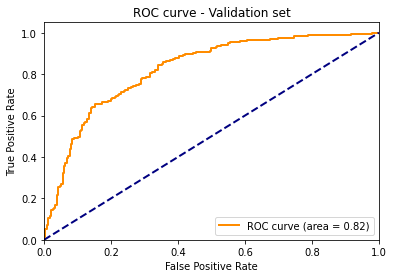

In [ ]:
fpr, tpr, _ = roc_curve(val_generator.classes, preds)
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve - Validation set')
plt.legend(loc="lower right")
plt.savefig(pathtoResults + 'roc_EQ_val.png')
plt.show()

#5. Plot ROC of test images

16/16 [==============================] - 11s 670ms/step


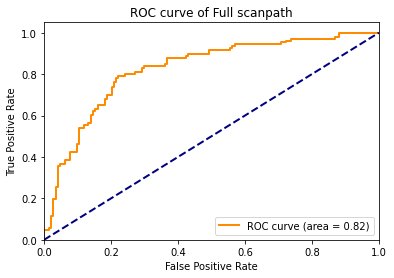

In [ ]:
# Full images
STEP_SIZE_TEST=test_generator_full_images.n//test_generator_full_images.batch_size
test_generator_full_images.reset()
preds = model.predict(test_generator_full_images,verbose=1)
fpr, tpr, _ = roc_curve(test_generator_full_images.classes, preds)
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve of Full scanpath')
plt.legend(loc="lower right")
plt.savefig(pathtoResults + 'roc_EQ_full.png')
plt.show()

16/16 [==============================] - 10s 594ms/step


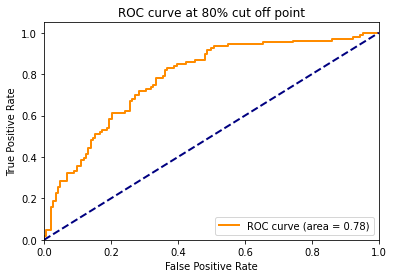

In [ ]:
# 80 percent
STEP_SIZE_TEST=test_generator_80_percent.n//test_generator_80_percent.batch_size
test_generator_80_percent.reset()
preds = model.predict(test_generator_80_percent,verbose=1)
fpr, tpr, _ = roc_curve(test_generator_80_percent.classes, preds)
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve at 80% cut off point')
plt.legend(loc="lower right")
plt.savefig(pathtoResults + 'roc_EQ_80.png')
plt.show()

16/16 [==============================] - 9s 582ms/step


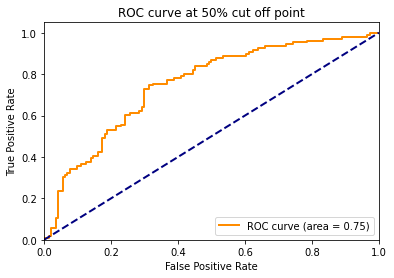

In [ ]:
# 50 percent
STEP_SIZE_TEST=test_generator_50_percent.n//test_generator_50_percent.batch_size
test_generator_50_percent.reset()
preds = model.predict(test_generator_50_percent,verbose=1)
fpr, tpr, _ = roc_curve(test_generator_50_percent.classes, preds)
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve at 50% cut off point')
plt.legend(loc="lower right")
plt.savefig(pathtoResults + 'roc_EQ_50.png')
plt.show()

16/16 [==============================] - 9s 575ms/step


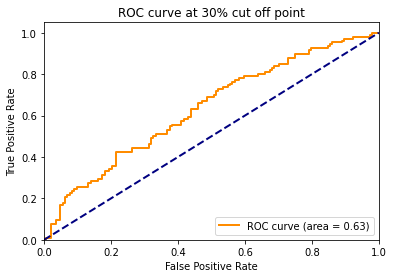

In [ ]:
# 30 percent
STEP_SIZE_TEST=test_generator_30_percent.n//test_generator_30_percent.batch_size
test_generator_30_percent.reset()
preds = model.predict(test_generator_30_percent,verbose=1)
fpr, tpr, _ = roc_curve(test_generator_30_percent.classes, preds)
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve at 30% cut off point')
plt.legend(loc="lower right")
plt.savefig(pathtoResults + 'roc_EQ_30.png')
plt.show()

16/16 [==============================] - 9s 575ms/step


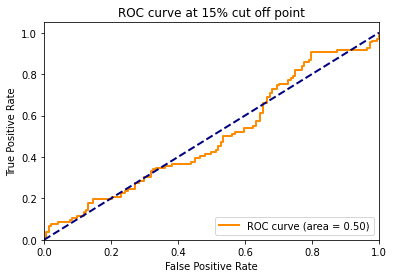

In [ ]:
# 15 percent
STEP_SIZE_TEST=test_generator_15_percent.n//test_generator_15_percent.batch_size
test_generator_15_percent.reset()
preds = model.predict(test_generator_15_percent,verbose=1)
fpr, tpr, _ = roc_curve(test_generator_15_percent.classes, preds)
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve at 15% cut off point')
plt.legend(loc="lower right")
plt.savefig(pathtoResults + 'roc_EQ_15.png')
plt.show()

16/16 [==============================] - 10s 597ms/step


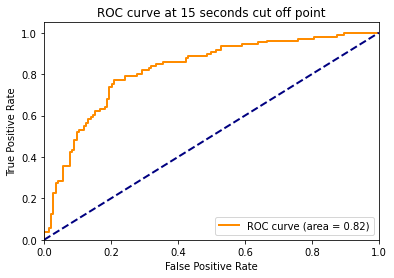

In [ ]:
# 15 seconds
STEP_SIZE_TEST=test_generator_15_secs.n//test_generator_15_secs.batch_size
test_generator_15_secs.reset()
preds = model.predict(test_generator_15_secs,verbose=1)
fpr, tpr, _ = roc_curve(test_generator_15_secs.classes, preds)
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve at 15 seconds cut off point')
plt.legend(loc="lower right")
plt.savefig(pathtoResults + 'roc_EQ_15s.png')
plt.show()

16/16 [==============================] - 9s 590ms/step


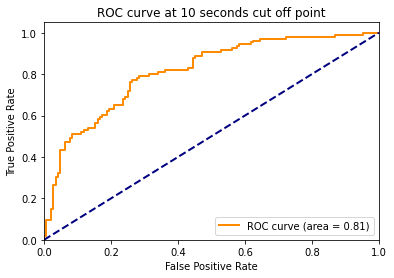

In [ ]:
# 10 seconds
STEP_SIZE_TEST=test_generator_10_secs.n//test_generator_10_secs.batch_size
test_generator_10_secs.reset()
preds = model.predict(test_generator_10_secs,verbose=1)
fpr, tpr, _ = roc_curve(test_generator_10_secs.classes, preds)
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve at 10 seconds cut off point')
plt.legend(loc="lower right")
plt.savefig(pathtoResults + 'roc_EQ_10s.png')
plt.show()

16/16 [==============================] - 9s 585ms/step


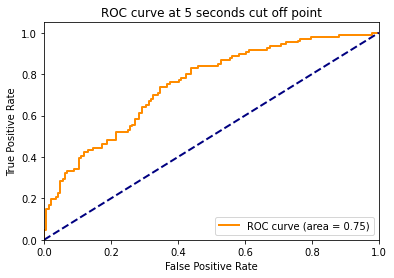

In [ ]:
# 5 seconds
STEP_SIZE_TEST=test_generator_5_secs.n//test_generator_5_secs.batch_size
test_generator_5_secs.reset()
preds = model.predict(test_generator_5_secs,verbose=1)
fpr, tpr, _ = roc_curve(test_generator_5_secs.classes, preds)
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve at 5 seconds cut off point')
plt.legend(loc="lower right")
plt.savefig(pathtoResults + 'roc_EQ_5s.png')
plt.show()

16/16 [==============================] - 9s 568ms/step


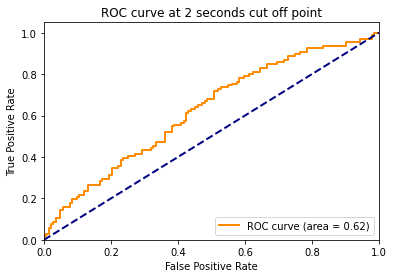

In [ ]:
# 2 seconds
STEP_SIZE_TEST=test_generator_2_secs.n//test_generator_2_secs.batch_size
test_generator_2_secs.reset()
preds = model.predict(test_generator_2_secs,verbose=1)
fpr, tpr, _ = roc_curve(test_generator_2_secs.classes, preds)
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve at 2 seconds cut off point')
plt.legend(loc="lower right")
plt.savefig(pathtoResults + 'roc_EQ_2s.png')
plt.show()